# Face Generation
In this project, I'll use generative adversarial networks to generate new images of faces.
### The Data
I've used two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex, I'll test the neural network on MNIST before CelebA.  Running the GANs on MNIST will allow to see how well the model trains, sooner.


In [1]:
#data_dir = './data'

# FloydHub - Used data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Exploring the Data
### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. 

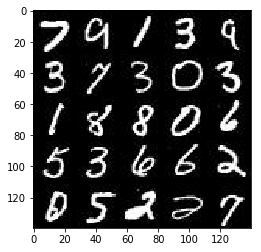

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  

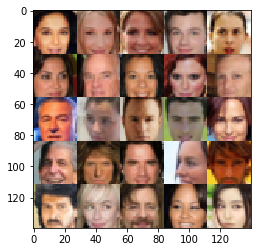

In [3]:
show_n_images = 25
#No annotations required since we'll be generating faces 
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocessing the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Building the Neural Network
I've build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

Note: Do check the version of Tensorflow and GPU access before starting.

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
The function `model_inputs` creates the following TF Placeholders for the Neural Network:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

The placeholders are returned in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate= tf.placeholder(tf.float32,(None),name='learning_rate')

    return real_inputs,z_inputs, learning_rate

tests.test_model_inputs(model_inputs)

Tests Passed


### The Discriminator lol
The discriminator neural network discriminates on `images`.  This function reuses the variables in the neural network using [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.

In [80]:
def discriminator(images, reuse=False):
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        #x1 = tf.contrib.layers.xavier_initializer_conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.layers.conv2d(images, filters=128, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)
        #x1 = tf.nn.dropout(x1, keep_prob=0.8)
        #print(x1.shape)
        # 14x14x64
         
        x2 = tf.layers.conv2d(x1, filters=256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training= True)
        x2 = tf.maximum(0.2 * x2, x2)
        #x2 = tf.nn.dropout(x2, keep_prob=0.8)
        
        
        #print(x2.shape)
        # 6x6x128
         
        x3 = tf.layers.conv2d(x2, filters=512, kernel_size=5, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training= True)
        x3 = tf.maximum(0.2 * x3, x3)
        #x3 = tf.nn.dropout(x3, keep_prob=0.8)
        print(x3.shape)
        # 4x4x256
        
        #x4 = tf.layers.conv2d(x3, filters=512, kernel_size=5, strides=2, padding='same')
        #x4 = tf.layers.batch_normalization(x4, training= True)
        #x4 = tf.maximum(0.2 * x4, x4)
        #x4 = tf.nn.dropout(x4, keep_prob=0.8)
        #print(x4.shape)
        # 2x2x512
        
        flat = tf.reshape(x3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits

    """
    def conv2d_layer(x):
        x = tf.layers.conv2d(x, int(x.get_shape()[3])*2, 5, strides =2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(0.2 * x, x)
        return x
    with tf.varaiable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides =2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)
        x2 = conv2d_layer(x1)
        x3 = conv2d_layer(x2)
        d1,d2,d3,d4 =list(x3.get_shape())
        x4 = tf.reshape(x3, (-1, int(d2)*int(d3)*int(d4)))
        logits = tf.layers.dense(x4,1)
        out =tf.sigmoid(logits)

    return out, logits
    """

tests.test_discriminator(discriminator, tf)

(?, 2, 2, 512)
(?, 2, 2, 512)
Tests Passed


### Generator
Implementing below `generator` to generate an image using `z`. The function returns the generated 28 x 28 x `out_channel_dim` images.

In [92]:
def generator(z, out_channel_dim, is_train=True):
   
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # first fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        #x1 = tf.nn.dropout(x1, keep_prob=0.8)
        #print('1st layer shape:', x1.shape)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=2, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2 * 0.2, x2)
        #x2 = tf.nn.dropout(x2, keep_prob=0.8)
        #print('2nd layer shape:', x2.shape)
        # 4x4x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3 * 0.2, x3)
        #x3 = tf.nn.dropout(x3, keep_prob=0.8)
        #print('3rd layer shape:', x3.shape)
        # 7x7x128
        
        x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4 * 0.2, x4)
        #x4 = tf.nn.dropout(x4, keep_prob=0.8)
        #print('4th layer shape:', x4.shape)
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(x4, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        #print('logits shape:', logits.shape)
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out


tests.test_generator(generator, tf)

Tests Passed


### Loss
Implementing `model_loss` to build the GANs for training and calculate the loss using the following functions already implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [93]:
def model_loss(input_real, input_z, out_channel_dim):
   
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    #d_loss_real = tf.reduce_mean(
        #tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss
    

tests.test_model_loss(model_loss)

(?, 2, 2, 512)
(?, 2, 2, 512)
Tests Passed


### Optimization
Implementing `model_opt` to create the optimization operations for the GANs. I've used [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  

In [94]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    #Filter the variables with names that are in the discriminator and generator scope names. 
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
This function shows the current output of the generator during training. It will help to determine how well the GANs is training.

In [95]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Training
Implementing `train` to build and train the GANs by using the following functions implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

I've used the `show_generator_output` to show `generator` output while training. Since running `show_generator_output` for every batch drastically increased training time and increased the size of the notebook, I printed the `generator` output every 100 batches only.

In [96]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
 
    # TODO: Build Model
    input_real, input_z, ln_rate = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)
    #print("train->input_real.get_shape: ", input_real.get_shape())
    #print("train->input_z.get_shape: ", input_z.get_shape())
    #print("train->learning_rate.get_shape: ", ln_rate.get_shape())
    
    
    input_real, input_z, ln_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt,  g_opt  = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    # Sample from random noise for G
    # batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample from random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Rescale the tanh logits to between -1,1
                batch_images = batch_images * 2.0
                
                # optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z,
                                                 ln_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_z: batch_z, input_real: batch_images,
                                                 ln_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_z: batch_z, input_real: batch_images,
                                                 ln_rate:learning_rate})
                
                if steps %20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, ln_rate:learning_rate})
                    
                    #train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images, ln_rate:learning_rate})
                    #train_loss_g = g_loss.eval({input_z: batch_z, ln_rate:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, ln_rate:learning_rate})
                    
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps %200 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                                                                                      
        #saver.save(sess, './checkpoints/generator.ckpt')
            

### MNIST
Testing the GANs architecture on MNIST.  

(?, 2, 2, 512)
(?, 2, 2, 512)
Epoch 1/2... Discriminator Loss: 5.3393... Generator Loss: 0.0082
Epoch 1/2... Discriminator Loss: 0.8644... Generator Loss: 1.7740
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 1.0323... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 0.6912
Epoch 1/2... Discriminator Loss: 0.9394... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.8708
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.5795
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.9375


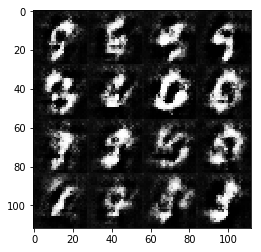

Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.8356
Epoch 1/2... Discriminator Loss: 0.9675... Generator Loss: 1.1822
Epoch 1/2... Discriminator Loss: 1.1372... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 1.3130
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 0.8530... Generator Loss: 1.2695
Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 1.6224


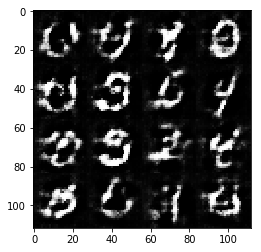

Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 1.4927
Epoch 1/2... Discriminator Loss: 0.9714... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 1.1345
Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 1.1630
Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 0.8200
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.6537... Generator Loss: 0.3516
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 0.7805


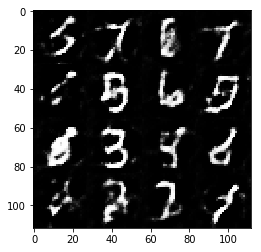

Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 0.9886... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 1.7479... Generator Loss: 0.3223
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 1.4753
Epoch 1/2... Discriminator Loss: 1.7233... Generator Loss: 0.3581
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.5237
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 1.4851


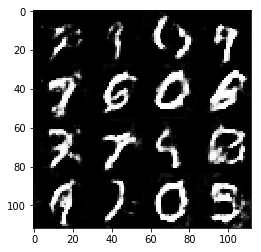

Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 1.2867
Epoch 1/2... Discriminator Loss: 2.0662... Generator Loss: 2.4327
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.5982
Epoch 1/2... Discriminator Loss: 2.2325... Generator Loss: 2.3644
Epoch 2/2... Discriminator Loss: 1.5121... Generator Loss: 0.4034
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.5541
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.5217... Generator Loss: 0.4243


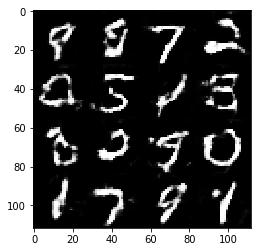

Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.5128
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.2083... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 0.8441
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 1.0267
Epoch 2/2... Discriminator Loss: 1.6668... Generator Loss: 0.3449
Epoch 2/2... Discriminator Loss: 1.2073... Generator Loss: 0.8900


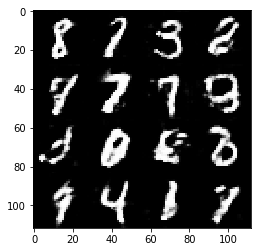

Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 1.3344
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 2.5641
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.4913
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 0.7007
Epoch 2/2... Discriminator Loss: 1.5144... Generator Loss: 2.3618
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 1.2278
Epoch 2/2... Discriminator Loss: 1.7210... Generator Loss: 0.3277


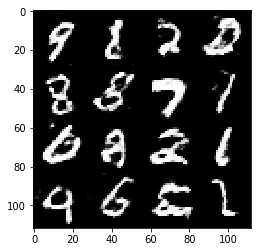

Epoch 2/2... Discriminator Loss: 1.4848... Generator Loss: 0.4474
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.5068
Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 0.6837
Epoch 2/2... Discriminator Loss: 1.4088... Generator Loss: 2.1505
Epoch 2/2... Discriminator Loss: 1.9533... Generator Loss: 0.2603
Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.3794
Epoch 2/2... Discriminator Loss: 1.5493... Generator Loss: 0.3981
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.5898
Epoch 2/2... Discriminator Loss: 1.7250... Generator Loss: 0.3125
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 1.3463


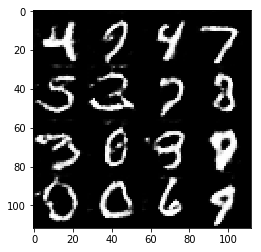

Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.8102
Epoch 2/2... Discriminator Loss: 1.8356... Generator Loss: 0.3607
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 1.0908... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 0.6010
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.5721
Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 0.6811
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 1.1899
Epoch 2/2... Discriminator Loss: 1.1473... Generator Loss: 0.6923
Epoch 2/2... Discriminator Loss: 3.1868... Generator Loss: 0.1013


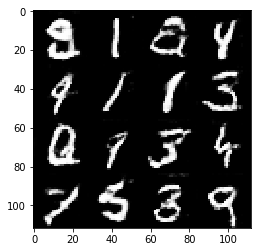

Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.5263
Epoch 2/2... Discriminator Loss: 1.8484... Generator Loss: 0.2892
Epoch 2/2... Discriminator Loss: 1.7860... Generator Loss: 0.3290


In [97]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Since The Generator loss is close to zero so running the GANs on CelebA.  

(?, 2, 2, 512)
(?, 2, 2, 512)
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 8.8293
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 4.9449
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 4.5836
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 3.3332
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 2.1969... Generator Loss: 0.7641


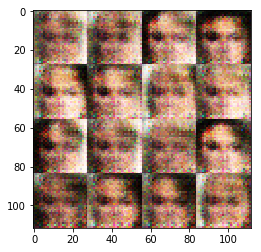

Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.7411... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.3791
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.2371


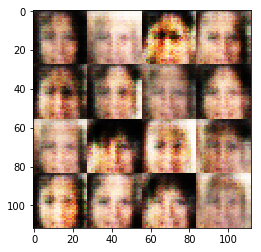

Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.9328


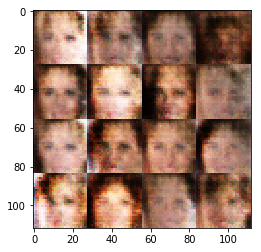

Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.9080


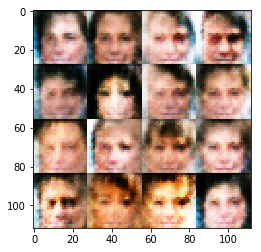

Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 1.3950
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.7710


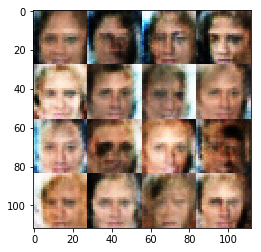

Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.7847


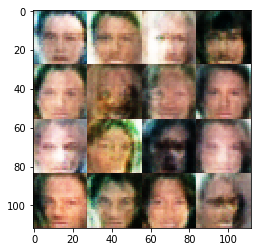

Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7243


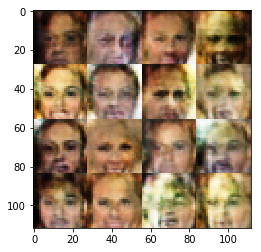

Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6411


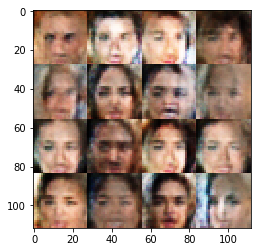

Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.7278... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.8824


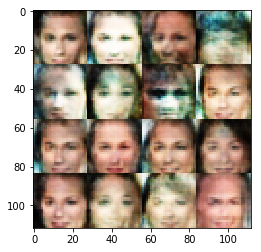

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.7205... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.5774


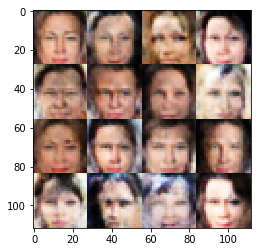

Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 1.0454


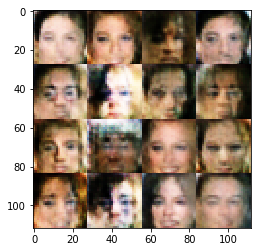

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.5968


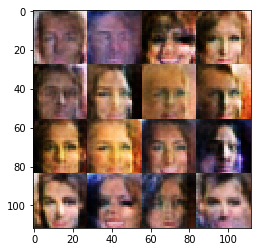

Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.3382
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 1.3954
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6658


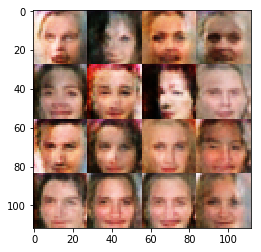

Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.4539


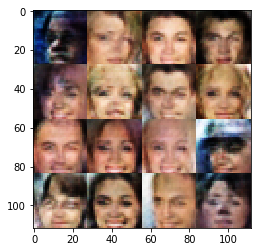

Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.4889


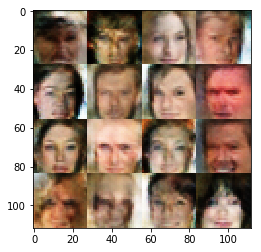

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.4941


In [98]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)